In [13]:
!pip install tqdm
!pip install kaggle

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm import tqdm
from google.colab import drive, files
import matplotlib.pyplot as plt

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
'''
* training_recognition_ai(): resnet18을 로드한 후, Fine-tuning을 진행하는 함수
* parameter
* 1. train_dataset: 전처리를 거친 Training Dataset
* 2. val_dataset: 전처리를 거친 Validation Dataset
* 3. save_dir: Finetuning을 마친 모델을 저장할 경로
'''
def training_recognition_ai(train_dataset, val_dataset, save_dir):

    # 데이터로더 설정
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # 클래스 수 설정
    class_names = train_dataset.classes

    # GPU 사용 여부 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 미리 학습된 ResNet-18 모델 불러오기
    model = models.resnet18(pretrained=True)

    # 새로운 분류기 추가 (Fine-tuning을 위해 마지막 Fully Connected 레이어를 변경)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))

    # GPU 또는 CPU에 모델 올리기
    model = model.to(device)

    # 손실 함수 정의
    criterion = nn.CrossEntropyLoss()

    # 옵티마이저 정의 (SGD를 사용하며, 매개변수 및 학습률 조절을 위해 scheduler 사용)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # 7 에폭마다 학습률을 감소시키는 스케줄러
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Epoch별 결과값 배열
    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    # 모델 학습
    num_epochs = 10
    for epoch in range(num_epochs):

        # 학습과 검증을 번갈아가면서 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드 설정
                dataloader = tqdm(train_dataloader, desc=f'Training Epoch {epoch}', position=0, leave=True)
            else:
                model.eval()   # 평가 모드 설정
                dataloader = tqdm(val_dataloader, desc=f'Validation Epoch {epoch}', position=0, leave=True)

            running_loss = 0.0
            running_corrects = 0

            # 데이터 반복
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # 매개변수 경사도 초기화
                optimizer.zero_grad()

                # 순전파
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 및 옵티마이저 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    dataloader.set_postfix({'Loss': loss.item()})

            # 에폭 당 손실과 정확도 계산
            epoch_loss = running_loss / len(train_dataloader.dataset) if phase == 'train' else running_loss / len(val_dataloader.dataset)
            epoch_acc = running_corrects.double() / len(train_dataloader.dataset) if phase == 'train' else running_corrects.double() / len(val_dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc)
        # 학습률 스케줄러 업데이트
        exp_lr_scheduler.step()

    # 모델 저장
    torch.save(model, save_dir)

    # 그래프 그리기
    plot_result(train_losses, train_acc, val_losses, val_acc)


In [17]:
'''
* plot_result(): Training Loss, Training Accuracy, Validation Loss, Validation Accuracy를 plot하는 함수
* parameter
* 1. train_losses: Epoch별 Training Loss 배열
* 2. train_acc: Epoch별 Training Accuracy 배열
* 3. val_losses: Epoch별 Validation Loss 배열
* 4. val_acc: Epoch별 Validation Accuracy 배열
'''
def plot_result(train_losses, train_acc, val_losses, val_acc):
    epochs = range(1, len(train_losses) + 1)

    # Training Loss와 Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training Accuracy와 Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
    ]),
}

1. Kaggle 사이트에서 fruit-and-vegitable-image 데이터셋을 다운받고, 압축을 해제한다.

In [19]:
# Kaggle.json 파일을 /root/.kaggle/ 디렉토리로 복사
!mkdir -p /root/.kaggle/
!cp /content/drive/MyDrive/Recipes_ChatBot/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Kaggle에서 데이터셋 다운로드
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

# 다운로드된 ZIP 파일 압축 해제
!unzip -q fruit-and-vegetable-image-recognition.zip -d /content/drive/MyDrive/Recipes_ChatBot/data/fruit-and-vegetable-image-recognition

fruit-and-vegetable-image-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/drive/MyDrive/Recipes_ChatBot/data/fruit-and-vegetable-image-recognition/test/apple/Image_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

2. 다운받은 데이터셋을 전처리하여 **train_dataset**과 **val_dataset**에 저장하고, Training이 끝난 다음 모델을 저장할 경로를 **save_dir**에 저장한다.

In [20]:
# 음식 재료 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/Recipes_ChatBot/data/fruit-and-vegetable-image-recognition'

# torchvision.datasets로 데이터셋 다운로드
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=data_transforms['val'])
save_dir = '/content/drive/MyDrive/Recipes_ChatBot/food_ingredient_recognition_model.pth'

# class 출력
train_dataset.classes

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

3. ImageNet으로 Pre-trained된 resnet18을 로드한 후, fruit-and-vegetable-image 데이터셋으로 Fine-tuning하는 **Transfer learning**을 진행한다.
(참고: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

Training Epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 0:  50%|█████     | 49/98 [09:01<08:19, 10.19s/it, Loss=2.8]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 0: 100%|██████████| 98/98 [17:41<00:00, 10.83s/it, Loss=1.35]


train Loss: 2.6852 Acc: 0.3544


Validation Epoch 0: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]


val Loss: 1.0405 Acc: 0.8050


Training Epoch 1:  33%|███▎      | 32/98 [05:56<11:23, 10.36s/it, Loss=1.12]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 1:  58%|█████▊    | 57/98 [10:29<07:52, 11.52s/it, Loss=1.07]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 1: 100%|██████████| 98/98 [17:48<00:00, 10.90s/it, Loss=1.09]


train Loss: 1.3328 Acc: 0.6960


Validation Epoch 1: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]


val Loss: 0.5227 Acc: 0.8579


Training Epoch 2:   3%|▎         | 3/98 [00:35<18:20, 11.58s/it, Loss=0.805]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 2:  37%|███▋      | 36/98 [06:37<11:12, 10.84s/it, Loss=1.12]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 2: 100%|██████████| 98/98 [17:43<00:00, 10.86s/it, Loss=0.693]


train Loss: 0.9559 Acc: 0.7490


Validation Epoch 2: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]


val Loss: 0.3725 Acc: 0.8997


Training Epoch 3:   5%|▌         | 5/98 [01:01<17:36, 11.36s/it, Loss=0.916]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 3:  12%|█▏        | 12/98 [02:16<15:34, 10.86s/it, Loss=1.03]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 3: 100%|██████████| 98/98 [17:21<00:00, 10.63s/it, Loss=1.76]


train Loss: 0.7807 Acc: 0.7913


Validation Epoch 3: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]


val Loss: 0.3153 Acc: 0.9025


Training Epoch 4:   9%|▉         | 9/98 [01:38<15:18, 10.32s/it, Loss=0.956]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 4:  14%|█▍        | 14/98 [02:28<14:15, 10.19s/it, Loss=0.434]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 4: 100%|██████████| 98/98 [16:36<00:00, 10.16s/it, Loss=1.23]


train Loss: 0.6891 Acc: 0.8090


Validation Epoch 4: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]


val Loss: 0.2738 Acc: 0.9192


Training Epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 5:  22%|██▏       | 22/98 [03:53<13:03, 10.30s/it, Loss=0.425]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 5: 100%|██████████| 98/98 [16:37<00:00, 10.18s/it, Loss=0.711]


train Loss: 0.6309 Acc: 0.8189


Validation Epoch 5: 100%|██████████| 12/12 [00:51<00:00,  4.28s/it]


val Loss: 0.2785 Acc: 0.9192


Training Epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 6:   6%|▌         | 6/98 [01:08<16:15, 10.60s/it, Loss=0.516]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 6: 100%|██████████| 98/98 [16:41<00:00, 10.22s/it, Loss=0.747]


train Loss: 0.5852 Acc: 0.8305


Validation Epoch 6: 100%|██████████| 12/12 [00:50<00:00,  4.22s/it]


val Loss: 0.2524 Acc: 0.9136


Training Epoch 7:   8%|▊         | 8/98 [01:25<14:34,  9.71s/it, Loss=0.428]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 7:  11%|█         | 11/98 [01:55<14:13,  9.81s/it, Loss=0.405]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 7: 100%|██████████| 98/98 [16:30<00:00, 10.11s/it, Loss=1.12]


train Loss: 0.5237 Acc: 0.8507


Validation Epoch 7: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]


val Loss: 0.2297 Acc: 0.9192


Training Epoch 8:   3%|▎         | 3/98 [00:40<19:21, 12.23s/it, Loss=0.685]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 8:   6%|▌         | 6/98 [01:11<16:42, 10.89s/it, Loss=0.758]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 8: 100%|██████████| 98/98 [16:42<00:00, 10.23s/it, Loss=0.583]


train Loss: 0.5122 Acc: 0.8636


Validation Epoch 8: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]


val Loss: 0.2254 Acc: 0.9192


Training Epoch 9:   9%|▉         | 9/98 [01:38<15:53, 10.72s/it, Loss=0.372]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 9:  14%|█▍        | 14/98 [02:29<14:20, 10.25s/it, Loss=0.678]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training Epoch 9: 100%|██████████| 98/98 [16:43<00:00, 10.24s/it, Loss=0.849]


train Loss: 0.4956 Acc: 0.8604


Validation Epoch 9: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]


val Loss: 0.2262 Acc: 0.9220


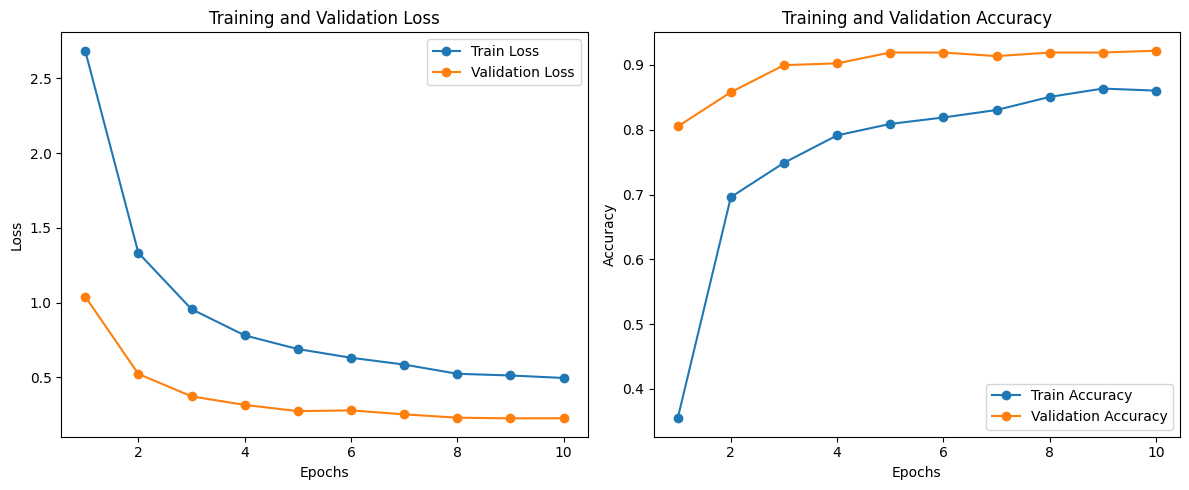

In [23]:
training_recognition_ai(train_dataset, val_dataset, save_dir)